# Analysis of coded budgetary values in notices

In [1]:
from collections import Counter
from dataclasses import dataclass

import pandas as pd
from matplotlib import pyplot as plt

## Data model definition

In [2]:
@dataclass(frozen=True)
class MonetaryValue:
    value: str | None
    currency: str | None


@dataclass(frozen=True)
class MonetaryRange:
    low: MonetaryValue
    high: MonetaryValue


@dataclass(frozen=True)
class ObjectMonetaryValues:
    lot_id: str | None
    values: tuple[MonetaryValue]


@dataclass(frozen=True)
class ObjectMonetaryRange:
    lot_id: str | None
    ranges: MonetaryRange


@dataclass(frozen=True)
class CodedValue:
    type_: str | None
    value: MonetaryValue | MonetaryRange


@dataclass(frozen=True)
class BudgetaryNotice:
    notice_id: str
    notice_type: str
    publication_date: str
    reference_notice_id: str
    version: str
    coded_value: list[CodedValue]
    object_contract_estimated_total_value: list[MonetaryValue]
    object_contract_total_value: list[MonetaryValue]
    object_contract_range_total_value: list[MonetaryRange]
    award_contract_estimated_total_value: list[MonetaryValue]
    award_contract_total_value: list[MonetaryValue]
    award_contract_range_total_value: list[MonetaryRange]
    object_value: list[ObjectMonetaryValues]
    contract_initial_estimated_total_value: list[MonetaryValue]
    quantity_range_total_value: list[ObjectMonetaryRange]

## Dataset loading

In [27]:
df = pd.read_csv("tmp/20230606-notice-budgetary-values-with-coded-values.csv", dtype="string")
df = df.fillna("")
for column in df.columns:
    if column.endswith("_value"):
        df[column] = df[column].apply(lambda x: eval(x))
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44300 entries, 0 to 44299
Data columns (total 15 columns):
 #   Column                                  Non-Null Count  Dtype 
---  ------                                  --------------  ----- 
 0   notice_id                               44300 non-null  string
 1   notice_type                             44300 non-null  string
 2   publication_date                        44300 non-null  string
 3   reference_notice_id                     44300 non-null  string
 4   version                                 44300 non-null  string
 5   coded_value                             44300 non-null  object
 6   object_contract_estimated_total_value   44300 non-null  object
 7   object_contract_total_value             44300 non-null  object
 8   object_contract_range_total_value       44300 non-null  object
 9   award_contract_estimated_total_value    44300 non-null  object
 10  award_contract_total_value              44300 non-null  object
 11  aw

notice_id             notice_type publication_date reference_notice_id  \
0  260146-2021         Contract notice         20210525   2021/S 046-114530   
1  448671-2015         Contract notice         20151222                       
2  450794-2016   Contract award notice         20161222                       
3  064176-2015         Contract notice         20150224                       
4  181172-2020  Additional information         20200420   2020/S 045-105610   

          version                                        coded_value  \
0  R2.0.9.S04.E01  [CodedValue(type_='ESTIMATED_TOTAL', value=Mon...   
1  R2.0.8.S02.E01                                                 []   
2  R2.0.9.S01.E01  [CodedValue(type_='PROCUREMENT_TOTAL', value=M...   
3  R2.0.8.S02.E01  [CodedValue(type_='GLOBAL', value=MonetaryValu...   
4  R2.0.8.S04.E01                                                 []   

               object_contract_estimated_total_value  \
0  [MonetaryValue(value='15200000.00', currency='...   
1                                                 []   
2                                                 []   
3                                                 []   
4                                                 []   

                         object_contract_total_value  \
0                                                 []   
1                                                 []   
2  [MonetaryValue(value='220100.00', currency='EU...   
3                                                 []   
4                                                 []   

  object_contract_range_total_value award_contract_estimated_total_value  \
0                                []                                   []   
1                                []                                   []   
2                                []                                   []   
3                                []                                   []   
4                                []                                   []   

                          award_contract_total_value  \
0                                                 []   
1                                                 []   
2  [MonetaryValue(value='220100.00', currency='EU...   
3                                                 []   
4                                                 []   

  award_contract_range_total_value  \
0                               []   
1                               []   
2                               []   
3                               []   
4                               []   

                                        object_value  \
0  [ObjectMonetaryValues(lot_id=None, values=(Mon...   
1                                                 []   
2                                                 []   
3                                                 []   
4                                                 []   

  contract_initial_estimated_total_value  \
0                                     []   
1                                     []   
2                                     []   
3                                     []   
4                                     []   

                          quantity_range_total_value  
0                                                 []  
1                                                 []  
2                                                 []  
3  [ObjectMonetaryRange(lot_id=None, ranges=Monet...  
4                                                 []

## Repartition of coded value types

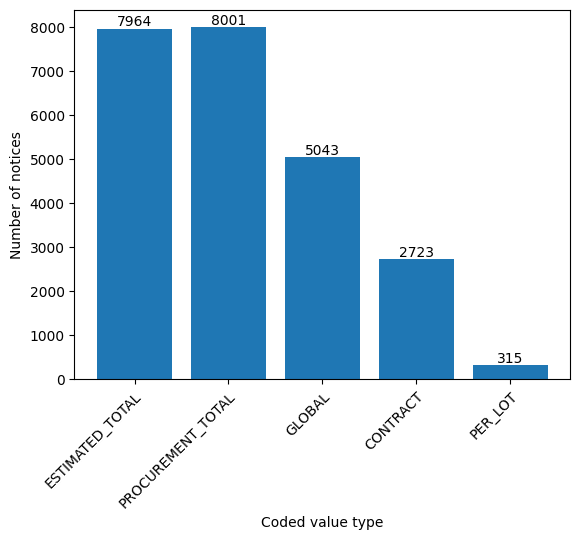

In [28]:
types = Counter([
    v
    for l in list(df["coded_value"])
    for v in {v.type_ for v in l}
])
rects = plt.bar(types.keys(), types.values())
plt.bar_label(rects)
plt.xticks(rotation=45, ha="right", rotation_mode="anchor")
plt.xlabel("Coded value type")
plt.ylabel("Number of notices")
plt.show()

## Correlation between coded values and other fields

In [41]:
df["coded_value"].apply(lambda c: has_coded_type(c, "PER_LOT")) & df["object_value"].apply(has_value)

0        False
1        False
2        False
3        False
4        False
         ...  
44295    False
44296    False
44297    False
44298    False
44299    False
Length: 44300, dtype: bool

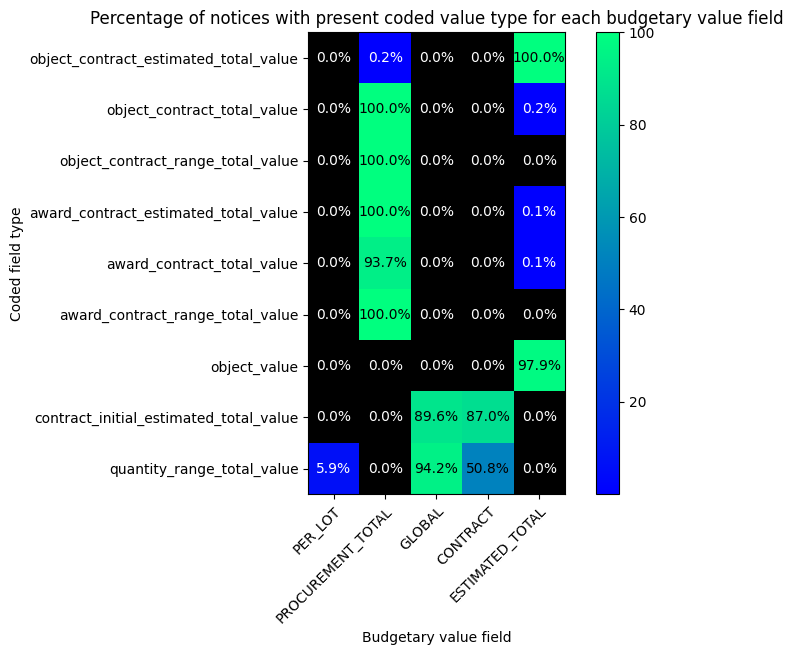

In [82]:
def has_coded_type(coded_values: list[CodedValue], type_: str) -> bool:
    return any(v.type_ == type_ for v in coded_values)


def has_value(field: list) -> bool:
    return len(field) > 0


value_fields = [c for c in df.columns if c.endswith("_value") and "coded" not in c]
coded_types = {v.type_ for l in list(df["coded_value"]) for v in l}
harvest = [
    [100
     * (df["coded_value"].apply(lambda c: has_coded_type(c, coded_type))
        & df[value_field].apply(has_value)).sum()
     / df[value_field].apply(has_value).sum()
     for coded_type in coded_types]
    for value_field in value_fields
]
plt.figure(figsize=(8, 6))
img = plt.imshow(harvest, cmap='winter', vmin=0.001)
img.cmap.set_under('black')
for i in range(len(value_fields)):
    for j in range(len(coded_types)):
        color = 'w' if harvest[i][j] < 50 else 'black'
        text = plt.text(j, i, f"{harvest[i][j]:.1f}%", ha="center", va="center", color=color)
plt.colorbar()
plt.xticks(range(len(coded_types)), labels=coded_types,
           rotation=45, ha="right", rotation_mode="anchor")
plt.yticks(range(len(value_fields)), labels=value_fields)
plt.title("Percentage of notices with present coded value type for each budgetary value field")
plt.xlabel("Budgetary value field")
plt.ylabel("Coded field type")
plt.show()

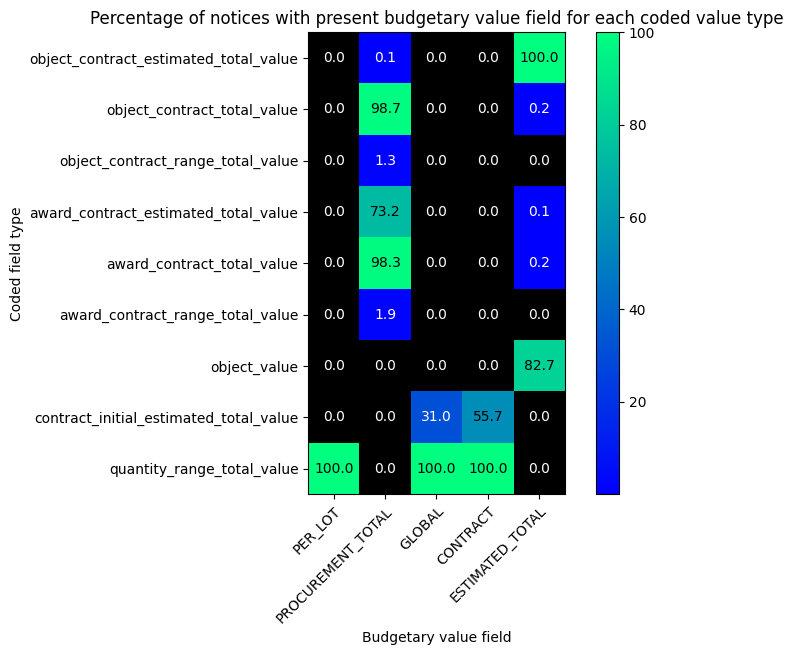

In [83]:
value_fields = [c for c in df.columns if c.endswith("_value") and "coded" not in c]
coded_types = {v.type_ for l in list(df["coded_value"]) for v in l}
harvest = [
    [100
     * (df["coded_value"].apply(lambda c: has_coded_type(c, coded_type))
        & df[value_field].apply(has_value)).sum()
     / df["coded_value"].apply(lambda c: has_coded_type(c, coded_type)).sum()
     for coded_type in coded_types]
    for value_field in value_fields
]
plt.figure(figsize=(8, 6))
img = plt.imshow(harvest, cmap='winter', vmin=0.001)
img.cmap.set_under('black')
for i in range(len(value_fields)):
    for j in range(len(coded_types)):
        color = 'w' if harvest[i][j] < 50 else 'black'
        text = plt.text(j, i, f"{harvest[i][j]:.1f}", ha="center", va="center", color=color)
plt.colorbar()
plt.xticks(range(len(coded_types)), labels=coded_types,
           rotation=45, ha="right", rotation_mode="anchor")
plt.yticks(range(len(value_fields)), labels=value_fields)
plt.title("Percentage of notices with present budgetary value field for each coded value type")
plt.xlabel("Budgetary value field")
plt.ylabel("Coded field type")
plt.show()

In [84]:
df[df["coded_value"].apply(lambda c: has_coded_type(c, "PROCUREMENT_TOTAL"))
   & (df["object_contract_total_value"].apply(has_value)
      | df["object_contract_range_total_value"].apply(has_value))]

notice_id            notice_type publication_date  \
2      450794-2016  Contract award notice         20161222   
13     260029-2017  Contract award notice         20170707   
22     480116-2019  Contract award notice         20191014   
25     206362-2022  Contract award notice         20220419   
31     281214-2019  Contract award notice         20190618   
...            ...                    ...              ...   
44256  131551-2017  Contract award notice         20170408   
44257  658461-2021  Contract award notice         20211223   
44263  222768-2022  Contract award notice         20220428   
44274  161732-2021  Contract award notice         20210402   
44296  036925-2022  Contract award notice         20220124   

      reference_notice_id         version  \
2                          R2.0.9.S01.E01   
13                         R2.0.9.S02.E01   
22                         R2.0.9.S03.E01   
25      2021/S 139-368669  R2.0.9.S05.E01   
31      2018/S 095-214654  R2.0.9.S03.E01   
...                   ...             ...   
44256   2016/S 246-448984  R2.0.9.S01.E01   
44257   2021/S 137-363803  R2.0.9.S05.E01   
44263   2021/S 240-628896  R2.0.9.S05.E01   
44274   2018/S 091-206089  R2.0.9.S04.E01   
44296   2021/S 140-371431  R2.0.9.S05.E01   

                                             coded_value  \
2      [CodedValue(type_='PROCUREMENT_TOTAL', value=M...   
13     [CodedValue(type_='PROCUREMENT_TOTAL', value=M...   
22     [CodedValue(type_='PROCUREMENT_TOTAL', value=M...   
25     [CodedValue(type_='PROCUREMENT_TOTAL', value=M...   
31     [CodedValue(type_='PROCUREMENT_TOTAL', value=M...   
...                                                  ...   
44256  [CodedValue(type_='PROCUREMENT_TOTAL', value=M...   
44257  [CodedValue(type_='PROCUREMENT_TOTAL', value=M...   
44263  [CodedValue(type_='PROCUREMENT_TOTAL', value=M...   
44274  [CodedValue(type_='PROCUREMENT_TOTAL', value=M...   
44296  [CodedValue(type_='PROCUREMENT_TOTAL', value=M...   

      object_contract_estimated_total_value  \
2                                        []   
13                                       []   
22                                       []   
25                                       []   
31                                       []   
...                                     ...   
44256                                    []   
44257                                    []   
44263                                    []   
44274                                    []   
44296                                    []   

                             object_contract_total_value  \
2      [MonetaryValue(value='220100.00', currency='EU...   
13       [MonetaryValue(value='460000', currency='EUR')]   
22     [MonetaryValue(value='520046.40', currency='EU...   
25     [MonetaryValue(value='238000.00', currency='EU...   
31     [MonetaryValue(value='1592250.00', currency='E...   
...                                                  ...   
44256  [MonetaryValue(value='8954400.00', currency='P...   
44257  [MonetaryValue(value='605160.00', currency='EU...   
44263  [MonetaryValue(value='2350000.00', currency='E...   
44274  [MonetaryValue(value='912595000.00', currency=...   
44296  [MonetaryValue(value='1835000.00', currency='E...   

      object_contract_range_total_value  \
2                                    []   
13                                   []   
22                                   []   
25                                   []   
31                                   []   
...                                 ...   
44256                                []   
44257                                []   
44263                                []   
44274                                []   
44296                                []   

                    award_contract_estimated_total_value  \
2                                                     []   
13                                                    []   
22     [MonetaryVal

In [85]:
df[df["coded_value"].apply(lambda c: has_coded_type(c, "PROCUREMENT_TOTAL"))
   & df["object_contract_total_value"].apply(has_value)]

notice_id            notice_type publication_date  \
2      450794-2016  Contract award notice         20161222   
13     260029-2017  Contract award notice         20170707   
22     480116-2019  Contract award notice         20191014   
25     206362-2022  Contract award notice         20220419   
31     281214-2019  Contract award notice         20190618   
...            ...                    ...              ...   
44256  131551-2017  Contract award notice         20170408   
44257  658461-2021  Contract award notice         20211223   
44263  222768-2022  Contract award notice         20220428   
44274  161732-2021  Contract award notice         20210402   
44296  036925-2022  Contract award notice         20220124   

      reference_notice_id         version  \
2                          R2.0.9.S01.E01   
13                         R2.0.9.S02.E01   
22                         R2.0.9.S03.E01   
25      2021/S 139-368669  R2.0.9.S05.E01   
31      2018/S 095-214654  R2.0.9.S03.E01   
...                   ...             ...   
44256   2016/S 246-448984  R2.0.9.S01.E01   
44257   2021/S 137-363803  R2.0.9.S05.E01   
44263   2021/S 240-628896  R2.0.9.S05.E01   
44274   2018/S 091-206089  R2.0.9.S04.E01   
44296   2021/S 140-371431  R2.0.9.S05.E01   

                                             coded_value  \
2      [CodedValue(type_='PROCUREMENT_TOTAL', value=M...   
13     [CodedValue(type_='PROCUREMENT_TOTAL', value=M...   
22     [CodedValue(type_='PROCUREMENT_TOTAL', value=M...   
25     [CodedValue(type_='PROCUREMENT_TOTAL', value=M...   
31     [CodedValue(type_='PROCUREMENT_TOTAL', value=M...   
...                                                  ...   
44256  [CodedValue(type_='PROCUREMENT_TOTAL', value=M...   
44257  [CodedValue(type_='PROCUREMENT_TOTAL', value=M...   
44263  [CodedValue(type_='PROCUREMENT_TOTAL', value=M...   
44274  [CodedValue(type_='PROCUREMENT_TOTAL', value=M...   
44296  [CodedValue(type_='PROCUREMENT_TOTAL', value=M...   

      object_contract_estimated_total_value  \
2                                        []   
13                                       []   
22                                       []   
25                                       []   
31                                       []   
...                                     ...   
44256                                    []   
44257                                    []   
44263                                    []   
44274                                    []   
44296                                    []   

                             object_contract_total_value  \
2      [MonetaryValue(value='220100.00', currency='EU...   
13       [MonetaryValue(value='460000', currency='EUR')]   
22     [MonetaryValue(value='520046.40', currency='EU...   
25     [MonetaryValue(value='238000.00', currency='EU...   
31     [MonetaryValue(value='1592250.00', currency='E...   
...                                                  ...   
44256  [MonetaryValue(value='8954400.00', currency='P...   
44257  [MonetaryValue(value='605160.00', currency='EU...   
44263  [MonetaryValue(value='2350000.00', currency='E...   
44274  [MonetaryValue(value='912595000.00', currency=...   
44296  [MonetaryValue(value='1835000.00', currency='E...   

      object_contract_range_total_value  \
2                                    []   
13                                   []   
22                                   []   
25                                   []   
31                                   []   
...                                 ...   
44256                                []   
44257                                []   
44263                                []   
44274                                []   
44296                                []   

                    award_contract_estimated_total_value  \
2                                                     []   
13                                                    []   
22     [MonetaryVal

In [86]:
df[df["coded_value"].apply(lambda c: has_coded_type(c, "ESTIMATED_TOTAL"))
   & df["object_contract_estimated_total_value"].apply(has_value)]

notice_id                                        notice_type  \
0      260146-2021                                    Contract notice   
14     555205-2020  Prior information notice without call for comp...   
19     249432-2018                                    Contract notice   
27     272861-2022                                    Contract notice   
28     395418-2021                                    Contract notice   
...            ...                                                ...   
44276  232115-2018                                    Contract notice   
44289  025421-2019                                    Contract notice   
44291  172692-2021                                    Contract notice   
44297  049966-2023                                    Contract notice   
44298  294702-2022  Prior information notice without call for comp...   

      publication_date reference_notice_id         version  \
0             20210525   2021/S 046-114530  R2.0.9.S04.E01   
14            20201120                      R2.0.9.S03.E01   
19            20180612                      R2.0.9.S02.E01   
27            20220523                      R2.0.9.S05.E01   
28            20210804                      R2.0.9.S04.E01   
...                ...                 ...             ...   
44276         20180531                      R2.0.9.S02.E01   
44289         20190118                      R2.0.9.S03.E01   
44291         20210407                      R2.0.9.S04.E01   
44297         20230125                      R2.0.9.S05.E01   
44298         20220603                      R2.0.9.S05.E01   

                                             coded_value  \
0      [CodedValue(type_='ESTIMATED_TOTAL', value=Mon...   
14     [CodedValue(type_='ESTIMATED_TOTAL', value=Mon...   
19     [CodedValue(type_='ESTIMATED_TOTAL', value=Mon...   
27     [CodedValue(type_='ESTIMATED_TOTAL', value=Mon...   
28     [CodedValue(type_='ESTIMATED_TOTAL', value=Mon...   
...                                                  ...   
44276  [CodedValue(type_='ESTIMATED_TOTAL', value=Mon...   
44289  [CodedValue(type_='ESTIMATED_TOTAL', value=Mon...   
44291  [CodedValue(type_='ESTIMATED_TOTAL', value=Mon...   
44297  [CodedValue(type_='ESTIMATED_TOTAL', value=Mon...   
44298  [CodedValue(type_='ESTIMATED_TOTAL', value=Mon...   

                   object_contract_estimated_total_value  \
0      [MonetaryValue(value='15200000.00', currency='...   
14     [MonetaryValue(value='666000.00', currency='EU...   
19     [MonetaryValue(value='3300000.00', currency='E...   
27     [MonetaryValue(value='1800000.00', currency='E...   
28     [MonetaryValue(value='2120000.00', currency='E...   
...                                                  ...   
44276  [MonetaryValue(value='8000000.00', currency='E...   
44289  [MonetaryValue(value='6000000.00', currency='E...   
44291  [MonetaryValue(value='3594100.00', currency='E...   
44297  [MonetaryValue(value='960000.00', currency='EU...   
44298  [MonetaryValue(value='54700000.00', currency='...   

      object_contract_total_value object_contract_range_total_value  \
0                              []                                []   
14                             []                                []   
19                             []                                []   
27                             []                                []   
28                             []                                []   
...                           ...                               ...   
44276                          []                                []   
44289                          []                                []   
44291                          []                                []   
44297                          []                                []   
44298                          []                                []   

      award_contract_estimated_total_value award_contract_total_value  \
0                  

In [87]:
df[df["coded_value"].apply(lambda c: has_coded_type(c, "PER_LOT"))
   & df["quantity_range_total_value"].apply(has_value)]

notice_id      notice_type publication_date reference_notice_id  \
105    412384-2015  Contract notice         20151124                       
174    121271-2015  Contract notice         20150408                       
260    189254-2014  Contract notice         20140606                       
295    224705-2017  Contract notice         20170614                       
482    374748-2015  Contract notice         20151024                       
...            ...              ...              ...                 ...   
43127  087481-2014  Contract notice         20140315                       
43412  195352-2014  Contract notice         20140612                       
43427  272372-2014  Contract notice         20140809                       
43916  445732-2014  Contract notice         20141231                       
44270  410618-2015  Contract notice         20151121                       

              version                                        coded_value  \
105    R2.0.8.S02.E01  [CodedValue(type_='PER_LOT', value=MonetaryVal...   
174    R2.0.8.S02.E01  [CodedValue(type_='PER_LOT', value=MonetaryVal...   
260    R2.0.8.S02.E01  [CodedValue(type_='PER_LOT', value=MonetaryRan...   
295    R2.0.8.S02.E01  [CodedValue(type_='GLOBAL', value=MonetaryValu...   
482    R2.0.8.S02.E01  [CodedValue(type_='GLOBAL', value=MonetaryValu...   
...               ...                                                ...   
43127  R2.0.8.S02.E01  [CodedValue(type_='GLOBAL', value=MonetaryRang...   
43412  R2.0.8.S02.E01  [CodedValue(type_='PER_LOT', value=MonetaryRan...   
43427  R2.0.8.S02.E01  [CodedValue(type_='GLOBAL', value=MonetaryValu...   
43916  R2.0.8.S02.E01  [CodedValue(type_='GLOBAL', value=MonetaryValu...   
44270  R2.0.8.S02.E01  [CodedValue(type_='PER_LOT', value=MonetaryVal...   

      object_contract_estimated_total_value object_contract_total_value  \
105                                      []                          []   
174                                      []                          []   
260                                      []                          []   
295                                      []                          []   
482                                      []                          []   
...                                     ...                         ...   
43127                                    []                          []   
43412                                    []                          []   
43427                                    []                          []   
43916                                    []                          []   
44270                                    []                          []   

      object_contract_range_total_value award_contract_estimated_total_value  \
105                                  []                                   []   
174                                  []                                   []   
260                                  []                                   []   
295                                  []                                   []   
482                                  []                                   []   
...                                 ...                                  ...   
43127                                []                                   []   
43412                                []                                   []   
43427                                []                                   []   
43916                                []                                   []   
44270                                []                                   []   

      award_contract_total_value award_contract_range_total_value  \
105                           []                               []   
174                           []                               []   
260                           []                               []   
295                           []             

In [88]:
df[df["coded_value"].apply(lambda c: has_coded_type(c, "CONTRACT"))
   & df["quantity_range_total_value"].apply(has_value)]

notice_id            notice_type publication_date  \
20     365039-2015  Contract award notice         20151017   
26     445707-2014         Contract award         20141231   
37     016016-2015         Contract award         20150117   
43     157959-2015  Contract award notice         20150507   
44     026878-2014         Contract award         20140125   
...            ...                    ...              ...   
44269  211214-2016  Contract award notice         20160622   
44280  408181-2014         Contract award         20141202   
44283  414314-2015  Contract award notice         20151125   
44288  043933-2014         Contract award         20140208   
44292  383076-2014         Contract award         20141111   

      reference_notice_id         version  \
20       2015/S 94-167845  R2.0.8.S02.E01   
26      2014/S 155-277655  R2.0.8.S02.E01   
37      2014/S 134-239648  R2.0.8.S02.E01   
43      2014/S 105-184180  R2.0.8.S02.E01   
44      2013/S 151-261859  R2.0.8.S02.E01   
...                   ...             ...   
44269   2015/S 231-418940  R2.0.8.S02.E01   
44280   2014/S 134-239653  R2.0.8.S02.E01   
44283    2015/S 56-096718  R2.0.8.S02.E01   
44288   2013/S 113-192327  R2.0.8.S02.E01   
44292   2011/S 175-286403  R2.0.8.S02.E01   

                                             coded_value  \
20     [CodedValue(type_='CONTRACT', value=MonetaryVa...   
26     [CodedValue(type_='CONTRACT', value=MonetaryVa...   
37     [CodedValue(type_='GLOBAL', value=MonetaryValu...   
43     [CodedValue(type_='CONTRACT', value=MonetaryVa...   
44     [CodedValue(type_='CONTRACT', value=MonetaryVa...   
...                                                  ...   
44269  [CodedValue(type_='GLOBAL', value=MonetaryValu...   
44280  [CodedValue(type_='CONTRACT', value=MonetaryVa...   
44283  [CodedValue(type_='CONTRACT', value=MonetaryVa...   
44288  [CodedValue(type_='CONTRACT', value=MonetaryVa...   
44292  [CodedValue(type_='CONTRACT', value=MonetaryVa...   

      object_contract_estimated_total_value object_contract_total_value  \
20                                       []                          []   
26                                       []                          []   
37                                       []                          []   
43                                       []                          []   
44                                       []                          []   
...                                     ...                         ...   
44269                                    []                          []   
44280                                    []                          []   
44283                                    []                          []   
44288                                    []                          []   
44292                                    []                          []   

      object_contract_range_total_value award_contract_estimated_total_value  \
20                                   []                                   []   
26                                   []                                   []   
37                                   []                                   []   
43                                   []                                   []   
44                                   []                                   []   
...                                 ...                                  ...   
44269                                []                                   []   
44280                                []                                   []   
44283                                []                                   []   
44288                                []                                   []   
44292                                []                                   []   

      award_contract_total_value award_contract_range_total_value  \
20                            []                               []   
26

- We observe that:
    - There is a clear link between coded values and other fields:
        - PROCUREMENT_TOTAL value = object_contract_total_value
        - PROCUREMENT_TOTAL range = object_contract_range_total_value
        - ESTIMATED_TOTAL = object_contract_estimated_total_value
        - PER_LOT = quantity_range_total_value (when lot != None)
        - CONTRACT = quantity_range_total_value (when lot == None or lot != None)
        - GLOBAL = quantity_range_total_value (when lot == None)
    - Multiples cases for quantity_range_total_value:
        - 328533-2015, 016016-2015
            - quantity_range_total_value lot = CONTRACT
            - quantity_range_total_value not lot = GLOBAL
        - 412384-2015
            - quantity_range_total_value lot = PER_LOT
            - quantity_range_total_value not lot = GLOBAL
        - => It is probably easier to take quantity_range_total_value directly
- Difference between GLOBAL and PROCUREMENT_TOTAL ?
- Coded values are free text and not always easily parsable values (not consistent use of ",", ".", " ", unicode characters, ...), so probably safer to use associated fields